In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
site_key = 'Carp'
freq_key = 'LF'

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)
bout_params

{'site_key': 'Carp', 'LF_bci': 2441.57728714914}

In [5]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)
bout_metrics

In [ ]:
def plot_ipi_hist(bout_metrics, fig_details):
    """
    Plots a histogram of IPIs from a provided location and frequency group for the specified range of intervals and bin width.
    """

    ipis_ms = clstr.get_valid_ipis_ms(location_df)

    plt.rcParams.update({'font.size' : 20})
    plt.figure(figsize=(12, 6))
    plt.title(f"Frequency histogram for {fig_details['freq_group']}inter-pulse intervals {fig_details['site_name']} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
    hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
    histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
    plt.grid(axis='y')
    bin_ticks = hist_bins.round(3)
    bin_labels = [''] * len(bin_ticks)

    bin_labels[::fig_details['time_end']//(10*fig_details['bin_step'])] = bin_ticks[::fig_details['time_end']//(10*fig_details['bin_step'])]

    plt.xticks(bin_ticks, bin_labels, rotation=45)
    plt.ylabel('# of intervals', fontsize=20)
    plt.xlabel('Time (ms)', loc='left', fontsize=20)
    plt.xlim(0, fig_details['time_end'])
    plt.tight_layout()
    plt.show()

    return ipis_ms, histogram

In [ ]:
def get_log_survival(hist_loc):
    """
    Computes and returns a log-survivorship curve provided a histogram.
    """

    values, base = hist_loc[0], hist_loc[1]
    cumulative = (np.cumsum(values[::-1]))[::-1]
    survival = np.log(cumulative)
    intervals_ms = base[:-1]

    return intervals_ms, survival

def calculate_exponential_coefficients(process):
    """
    Computes and returns the exponential coefficients given the slope and intercept of a process.
    Using equations from Sibly et al. (1990) and Slater & Lester (1982)
    """
    
    process['lambda'] = -1*process['metrics'].slope
    process['num_intervals_slater'] = np.exp(process['metrics'].intercept) / process['lambda']

    return process

def get_bci_from_fagenyoung_method(fast_process, slow_process):
    """
    Computes and returns the BCI given the lambda and N value for each process.
    Using the equation from Fagen & Young (1978) derived for minimizing total time misassigned.
    """

    bci = (1/(fast_process['lambda'] - slow_process['lambda'])) * np.log(fast_process['num_intervals_slater']/slow_process['num_intervals_slater'])

    misassigned_points = (fast_process['num_intervals_slater']*np.exp(-1*fast_process['lambda']*bci)) + (slow_process['num_intervals_slater']*(1 - np.exp(-1*slow_process['lambda']*bci)))

    return bci, misassigned_points

def get_bci_from_slater_method(fast_process, slow_process):
    """
    Computes and returns the BCI given the lambda and N value for each process.
    Using the equation from Slater & Lester (1982) derived for minimizing # of events misassigned.
    """

    bci = (1/(fast_process['lambda'] - slow_process['lambda'])) * np.log((fast_process['num_intervals_slater']*fast_process['lambda'])/(slow_process['num_intervals_slater']*slow_process['lambda']))

    misassigned_points = (fast_process['num_intervals_slater']*np.exp(-1*fast_process['lambda']*bci)) + (slow_process['num_intervals_slater']*(1 - np.exp(-1*slow_process['lambda']*bci)))

    return bci, misassigned_points

def model(t, f_intervals, f_lambda, s_intervals, s_lambda):
    return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))

def get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process):
    """
    Computes and returns the BCI given the lambda and N value for each process.
    Using the equation from Sibly et al. (1990) derived using NLIN curve-fitting techniques to model the regression lines with a single curve.
    """

    x0 = np.array([fast_process['num_intervals_slater'], fast_process['lambda'], slow_process['num_intervals_slater'], slow_process['lambda']], dtype='float64')
    nlin_inds = np.concatenate([fast_process['indices'], np.where(slow_process['indices']==True)[0]])
    cfit_sols = scipy.optimize.curve_fit(model, intervals_ms[nlin_inds].astype('float64'), survival[nlin_inds].astype('float64'), p0=x0)
    nlin_results = dict()
    nlin_results['solution'] = cfit_sols[0]
    nlin_results['fast_num_intervals'] = nlin_results['solution'][0]
    nlin_results['fast_lambda'] = nlin_results['solution'][1]
    nlin_results['slow_num_intervals'] = nlin_results['solution'][2]
    nlin_results['slow_lambda'] = nlin_results['solution'][3]

    bci_coeff = (1/(nlin_results['fast_lambda'] - nlin_results['slow_lambda'])) 
    nlin_results['bci'] = bci_coeff * np.log((nlin_results['fast_num_intervals']*nlin_results['fast_lambda'])/(nlin_results['slow_num_intervals']*nlin_results['slow_lambda']))

    fast_misassignments = (nlin_results['fast_num_intervals']*np.exp(-1*nlin_results['fast_lambda']*nlin_results['bci']))
    slow_missasignments = (nlin_results['slow_num_intervals']*(1 - np.exp(-1*nlin_results['slow_lambda']*nlin_results['bci'])))
    misassigned_points_optim = fast_misassignments + slow_missasignments

    return nlin_results, misassigned_points_optim

In [ ]:
def plot_log_survival(intervals_ms, survival, fig_details):
    """
    Plots the log-survivorship curve of intervals with 10ms resolution with x-axis in minutes.
    """

    intervals_s = np.divide(intervals_ms, 1000).astype('int')
    intervals_min = np.divide(intervals_s, 60).astype('int')

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='navy')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', loc='left', fontsize=18)
    plt.xticks(intervals_ms[::180000], intervals_ms[::180000], rotation=45)
    plt.grid(which='both')
    plt.xlim(10, 10e6)
    plt.xscale("log")

    plt.tight_layout()
    plt.show()

def plot_fast_regression_results(intervals_ms, survival, fast_process, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the fast process
    """

    fast_start = (intervals_ms[fast_process['indices']][0])
    fast_end = (intervals_ms[fast_process['indices']][-1])

    print(f'Considering points from {fast_start} to {fast_end} for fast process')
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)

    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)
    plt.plot(intervals_ms[fast_process['indices']], survival[fast_process['indices']], marker='.', c='navy')
    plt.axvline(fast_start, linestyle='dashed', color='k')
    plt.axvline(fast_end, linestyle='dashed', color='k')

    x = np.linspace(-100, fig_details['time_end'])
    plt.plot(x, fast_process['metrics'].intercept + fast_process['metrics'].slope*x, c='red', marker=None, 
             label=f"R^2 = {round(fast_process['metrics'].rvalue**2, 4)}, Intercept = {round(fast_process['metrics'].intercept, 2)}, Slope = {round(fast_process['metrics'].slope, 8)}")

    plt.grid(axis='y')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(intervals_ms[0]-100, fig_details['time_end'])
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc='upper right')

    plt.show()

def plot_slow_regression_results(intervals_ms, survival, slow_process, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the slow process
    """

    slow_start = (intervals_ms[slow_process['indices']][0])
    slow_end = (intervals_ms[slow_process['indices']][-1])

    print(f'Considering points from {slow_start} to {slow_end} for slow process')
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)

    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)
    plt.plot(intervals_ms[slow_process['indices']], survival[slow_process['indices']], marker='.', c='navy')
    plt.axvline(slow_start, linestyle='dashed', color='k')
    plt.axvline(slow_end, linestyle='dashed', color='k')

    x = np.linspace(-100, intervals_ms[-1], int(slow_end))
    plt.plot(x, slow_process['metrics'].intercept + slow_process['metrics'].slope*x, c='blue', marker=None, alpha=0.8, 
             label=f"R^2 = {round(slow_process['metrics'].rvalue**2, 4)}, Intercept = {round(slow_process['metrics'].intercept, 2)}, Slope = {round(slow_process['metrics'].slope, 8)}")

    plt.grid(axis='y')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(intervals_ms[0], intervals_ms[-1])
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc='upper right')
    
    plt.show()

def plot_bci_over_survival(intervals_ms, survival, fast_process, slow_process, bci, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the both processs
    along with the derived BCI to see where it is in time.
    """

    fast_start = (intervals_ms[fast_process['indices']][0])
    fast_end = (intervals_ms[fast_process['indices']][-1])
    slow_start = (intervals_ms[slow_process['indices']][0])
    slow_end = (intervals_ms[slow_process['indices']][-1])

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)

    plt.plot(intervals_ms[fast_process['indices']], survival[fast_process['indices']], marker='.', c='navy')
    plt.plot(intervals_ms[slow_process['indices']], survival[slow_process['indices']], marker='.', c='navy')
    plt.axvline(fast_start, linestyle='dashed', color='k')
    plt.axvline(fast_end, linestyle='dashed', color='k')
    plt.axvline(slow_start, linestyle='dashed', color='k')
    plt.axvline(slow_end, linestyle='dashed', color='k')

    x = np.linspace(-100, intervals_ms[-1], int(slow_end))
    plt.plot(x, fast_process['metrics'].intercept + fast_process['metrics'].slope*x, c='red', alpha=0.6, marker=None, label=f"R^2 = {round(fast_process['metrics'].rvalue**2, 4)}")
    plt.plot(x, slow_process['metrics'].intercept + slow_process['metrics'].slope*x, c='blue', alpha=0.6, marker=None, label=f"R^2 = {round(slow_process['metrics'].rvalue**2, 4)}")

    plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
    plt.grid(axis='y')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(10e0, 10e7)
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.xscale("log")
    plt.show()

In [ ]:
def get_between_bout_intervals_ms(bout_metrics):
    
    intervals = bout_metrics['start_time_of_bout'] - bout_metrics['end_time_of_bout'].shift(1)
    bout_metrics.insert(0, 'between_bout_intervals', intervals)
    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bm_LF_df = bout_metrics.set_index('ref_time')
    first_calls_per_day = bm_LF_df.resample('D').first()['start_time_of_bout']
    first_valid_calls_per_day = pd.DatetimeIndex(first_calls_per_day.loc[~first_calls_per_day.isna()].values)
    bm_LF_df.loc[first_valid_calls_per_day, 'between_bout_intervals'] = pd.NaT
    intervals = bm_LF_df['between_bout_intervals'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_s = valid_intervals.astype('float32')/1e6

    return ipis_s

def plot_bbi_hist(bout_metrics, fig_details):
    """
    Plots a histogram of IPIs from a provided location and frequency group for the specified range of intervals and bin width.
    """

    ipis_ms = get_between_bout_intervals_ms(bout_metrics)

    plt.rcParams.update({'font.size' : 20})
    plt.figure(figsize=(12, 6))
    plt.title(f"Frequency histogram for {fig_details['freq_group']}between-bout intervals {fig_details['site_name']} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
    hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
    histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
    plt.grid(axis='y')
    bin_ticks = hist_bins.round(3)
    bin_labels = [''] * len(bin_ticks)

    bin_labels[::fig_details['time_end']//(10*fig_details['bin_step'])] = bin_ticks[::fig_details['time_end']//(10*fig_details['bin_step'])]

    plt.xticks(bin_ticks, bin_labels, rotation=45)
    plt.ylabel('# of intervals', fontsize=20)
    plt.xlabel('Time (ms)', loc='left', fontsize=20)
    plt.xlim(0, fig_details['time_end'])
    plt.tight_layout()
    plt.show()

    return ipis_ms, histogram


In [ ]:
bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 1000
fig_details['time_end'] = 180000
print(f'Looking at {fig_details["site_name"]} {fig_details["freq_group"]}')

Looking at Carp Pond LF 


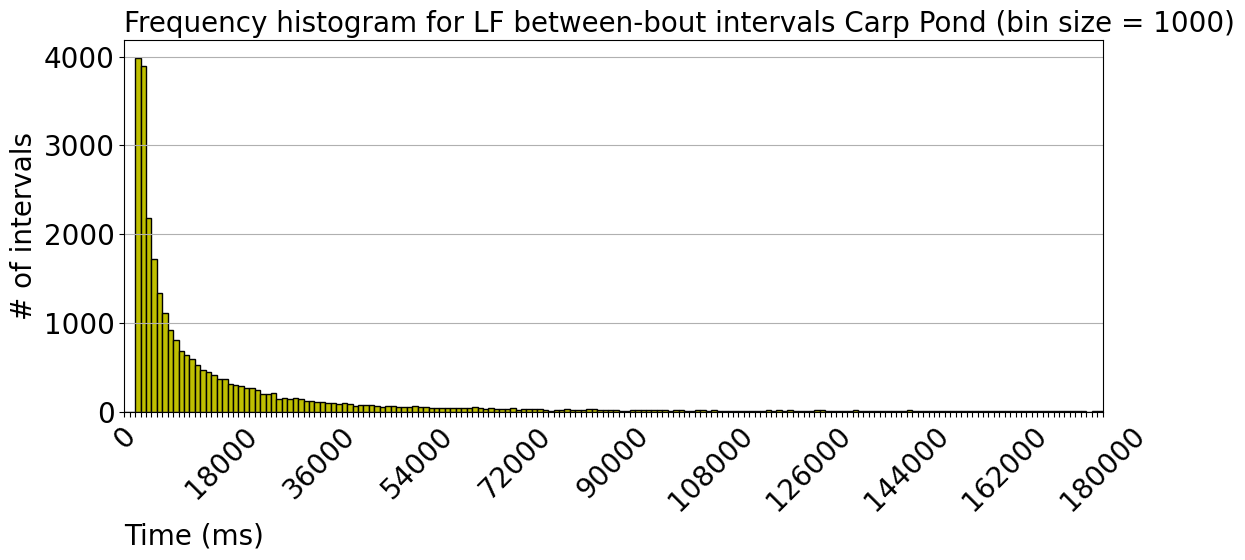

In [ ]:
plot_bbi_hist(bout_metrics.copy(), fig_details)
plt.show()

In [ ]:
def get_bbi_histogram(bout_metrics, bin_step):
    """
    Uses the IPIs from a location and for a frequency group to compute and return a complete histogram.
    The interval width is set to be 10ms to provide good resolution for the most common IPIs.
    """

    ipis_ms = get_between_bout_intervals_ms(bout_metrics)
    hist_loc = np.histogram(ipis_ms, bins=np.arange(0, ipis_ms.max()+bin_step, bin_step))

    return ipis_ms, hist_loc

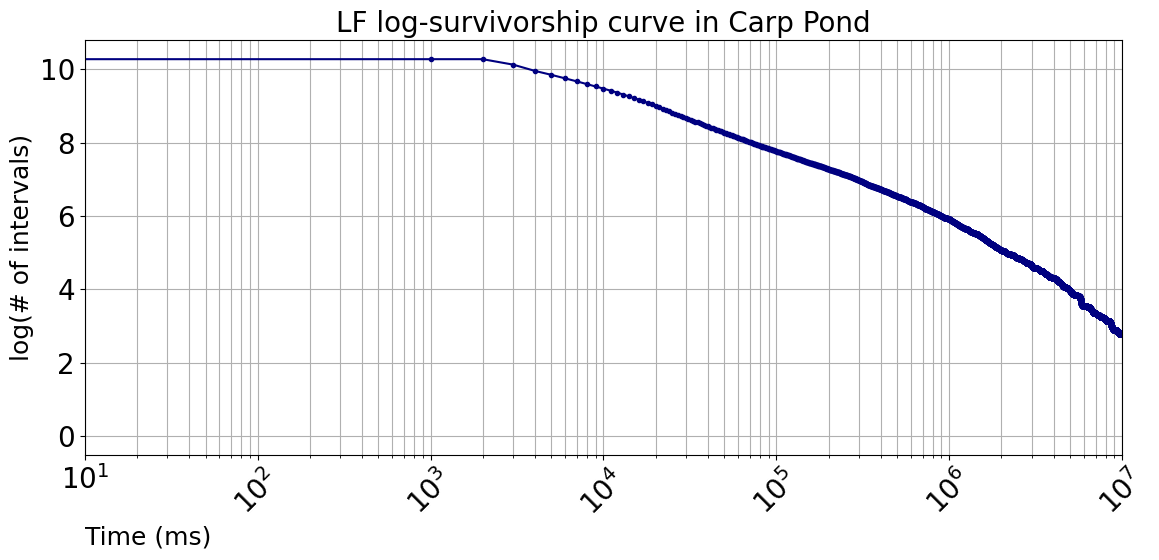

In [ ]:
ipis_loc, hist_loc = get_bbi_histogram(bout_metrics.copy(), fig_details['bin_step'])
intervals_ms, survival = get_log_survival(hist_loc)

plot_log_survival(intervals_ms, survival, fig_details)

In [ ]:
def regress_around_fast_intervals(intervals_ms, survival):
    """
    Use scipy.stats to compute linear regression coefficients around points
    we associate with between-bout intervals.
    """


    fast_inds = intervals_ms <= 10*1e3
    fast_coeff = stats.linregress(intervals_ms[fast_inds], survival[fast_inds])

    fast_process = dict()
    fast_process['metrics'] = fast_coeff
    fast_process['indices'] = fast_inds
    return fast_process

def regress_around_slow_intervals(intervals_ms, survival):
    """
    Use scipy.stats to compute linear regression coefficients around points
    we associate with between-bout intervals.

    These interval points to regress around are chosen using values between 30-40% of the max survival.
    We have observed that these points have a strong linear relationship.
    They are also among intervals from 20 to 60min. This range is very likely between-bout.
    """

    # slow_inds = np.logical_and(survival >= (survival.max() * 0.25), survival <= (survival.max() * 0.65)) 
    slow_inds = np.logical_and(intervals_ms >= 120*1e3, survival >= (survival.max() * 0.1))
    slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])

    slow_process = dict()
    slow_process['metrics'] = slow_coeff
    slow_process['indices'] = slow_inds
    return slow_process

In [ ]:
fast_process = regress_around_fast_intervals(intervals_ms, survival)
fast_process = calculate_exponential_coefficients(fast_process)

In [ ]:
slow_process = regress_around_slow_intervals(intervals_ms, survival)
slow_process =  calculate_exponential_coefficients(slow_process)

In [ ]:
fg_bci, misassigned_points_fg = get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 1021052053 missassigned points
Slater method has 18007772 missassigned points


/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_15410/1334928570.py:49: RuntimeWarning: overflow encountered in exp
  return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))
/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_15410/1334928570.py:49: RuntimeWarning: overflow encountered in multiply
  return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))
/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_15410/1334928570.py:49: RuntimeWarning: invalid value encountered in log
  return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))


Sibly method has 136627349 missassigned points
Optim BCI has less misassignments than BCI? False


In [ ]:
intervals_ms[fast_process['indices']][-1]

10000.0

In [ ]:
fast_start = (intervals_ms[fast_process['indices']][0])
fast_end = (intervals_ms[fast_process['indices']][-1])
slow_start = (intervals_ms[slow_process['indices']][0])
slow_end = (intervals_ms[slow_process['indices']][-1])

In [ ]:
def plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, optim_x, optim_bci, bci, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the both processs
    along with two derived BCIs (Slater BCI and Sibly BCI) to see where they are in time.
    """

    fast_start = (intervals_ms[fast_process['indices']][0])
    fast_end = (intervals_ms[fast_process['indices']][-1])
    slow_start = (intervals_ms[slow_process['indices']][0])
    slow_end = (intervals_ms[slow_process['indices']][-1])

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)

    plt.plot(intervals_ms, clstr.model(intervals_ms, optim_x[0], optim_x[1], optim_x[2], optim_x[3]), marker='.', c='green', alpha=0.1)
    plt.plot(intervals_ms[fast_process['indices']], survival[fast_process['indices']], marker='.', c='navy')
    plt.plot(intervals_ms[slow_process['indices']], survival[slow_process['indices']], marker='.', c='navy')
    plt.axvline(fast_start, linestyle='dashed', color='k')
    plt.axvline(fast_end, linestyle='dashed', color='k')
    plt.axvline(slow_start, linestyle='dashed', color='k')
    plt.axvline(slow_end, linestyle='dashed', color='k')

    x = np.linspace(-100, intervals_ms[-1], int(slow_end))
    plt.plot(x, fast_process['metrics'].intercept + fast_process['metrics'].slope*x, c='red', alpha=0.6, marker=None, label=f"R^2 = {round(fast_process['metrics'].rvalue**2, 4)}")
    plt.plot(x, slow_process['metrics'].intercept + slow_process['metrics'].slope*x, c='blue', alpha=0.6, marker=None, label=f"R^2 = {round(slow_process['metrics'].rvalue**2, 4)}")

    plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
    plt.axvline(optim_bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"Optim BCI: {round(optim_bci/1000, 2)}s")
    plt.grid(which='both')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(10e0, 10e6)
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc=3)
    plt.xscale("log")
    plt.show()

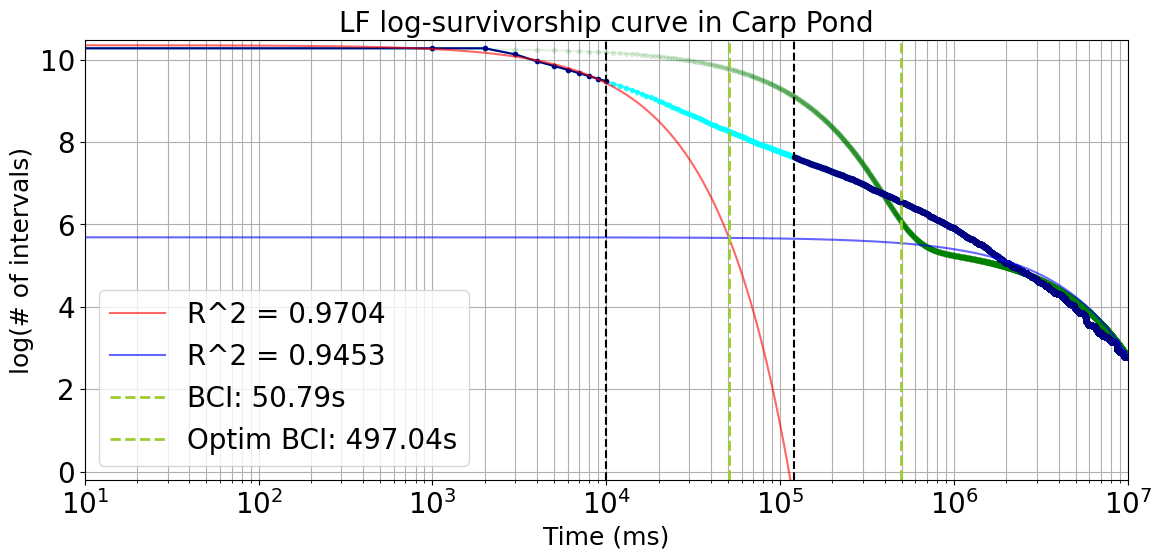

In [ ]:
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [ ]:
bout_params = bt.get_bout_params_from_location(location_df, data_params)
bout_params[f'LF_bci'] = bci

In [ ]:
bout_params

{'site_key': 'Carp', 'LF_bci': 2441.57728714914, 'HF_bci': 50790.74499334006}

In [ ]:
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)
bout_metrics

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,2022-07-13 04:55:13.597500,2022-07-13 04:55:23.927400,1513.5975,1523.9274,1513.5975,1523.9274,22890.0,33127.0,LF,2022-07-13 04:30:00,2022-07-13 04:30:00,37,0 days 00:00:10.329900,10.3299
1,2022-07-13 04:57:55.094500,2022-07-13 04:57:58.820900,1675.0945,1678.8209,1675.0945,1678.8209,26328.0,34097.0,LF,2022-07-13 04:30:00,2022-07-13 04:30:00,4,0 days 00:00:03.726400,3.7264
2,2022-07-13 05:05:25.821500,2022-07-13 05:05:28.472300,325.8215,328.4723,325.8215,328.4723,24609.0,29024.0,LF,2022-07-13 05:00:00,2022-07-13 05:00:00,6,0 days 00:00:02.650800,2.6508
3,2022-07-13 05:05:32.149500,2022-07-13 05:05:37.731600,332.1495,337.7316,332.1495,337.7316,23750.0,27951.0,LF,2022-07-13 05:00:00,2022-07-13 05:00:00,16,0 days 00:00:05.582100,5.5821
4,2022-07-13 05:05:47.819500,2022-07-13 05:05:51.224200,347.8195,351.2242,347.8195,351.2242,23750.0,30704.0,LF,2022-07-13 05:00:00,2022-07-13 05:00:00,8,0 days 00:00:03.404700,3.4047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29020,2022-10-17 06:43:12.782500,2022-10-17 06:43:17.846400,792.7825,797.8464,792.7825,797.8464,25468.0,32968.0,LF,2022-10-17 06:30:00,2022-10-17 06:30:00,22,0 days 00:00:05.063900,5.0639
29021,2022-10-17 07:56:34.765500,2022-10-17 07:56:42.410600,1594.7655,1602.4106,1594.7655,1602.4106,24609.0,31057.0,LF,2022-10-17 07:30:00,2022-10-17 07:30:00,16,0 days 00:00:07.645100,7.6451
29022,2022-10-17 13:42:00.610500,2022-10-17 13:42:03.572400,720.6105,723.5724,720.6105,723.5724,25468.0,34757.0,LF,2022-10-17 13:30:00,2022-10-17 13:30:00,11,0 days 00:00:02.961900,2.9619
29023,2022-10-17 13:42:44.747500,2022-10-17 13:42:45.369800,764.7475,765.3698,764.7475,765.3698,28046.0,36466.0,LF,2022-10-17 13:30:00,2022-10-17 13:30:00,3,0 days 00:00:00.622300,0.6223


In [ ]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
single_night_files = files_from_loc[:21]

In [ ]:
def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    # plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='k', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_bouts.empty):
        plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        btp_per_cycle = actvt.get_btp_per_time_on(bout_duration_per_cycle, data_params['time_on_in_secs'])
        plot_recording_periods_with_btp(ax, audio_features, data_params, np.round(btp_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()

def plot_bout_info(ax, audio_features, plot_bouts):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    for i, row in plot_bouts.iterrows():
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=((row['low_freq']-6000)/(fs/2)), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='green', weight='bold', fontsize=14)
        # plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=((row['high_freq']+2000)/(fs/2)), 
        #                     s=f"{round(row['number_of_dets'], 2)} dets", color='red', weight='bold', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)


def plot_recording_periods_with_btp(ax, audio_features, data_params, btp_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.10, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold', alpha=0.6)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.10, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold', alpha=0.6)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.10, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold', alpha=0.6)
                window_count+=1
            ax.add_patch(rect)


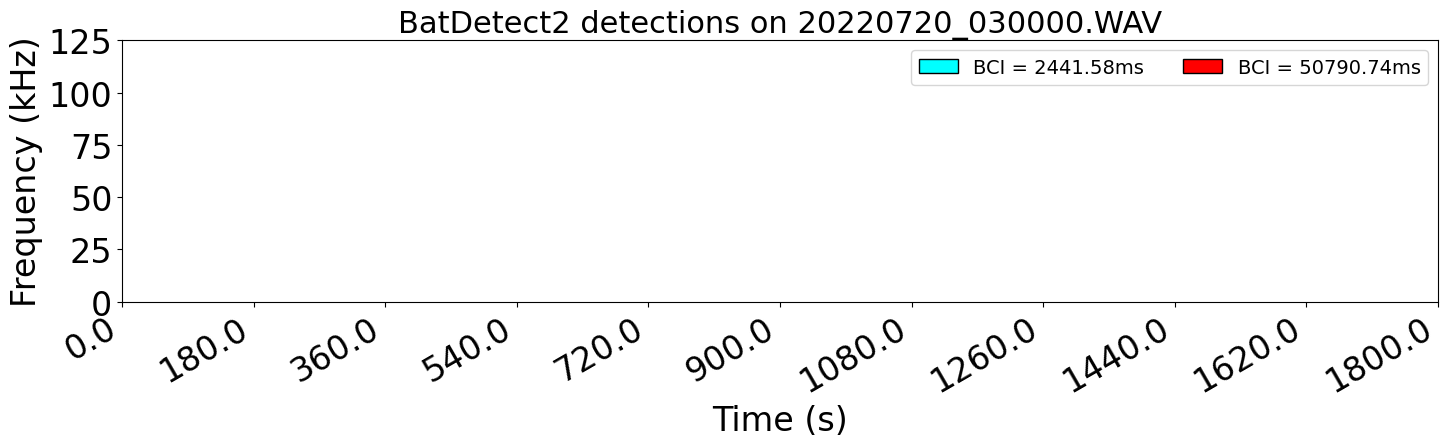

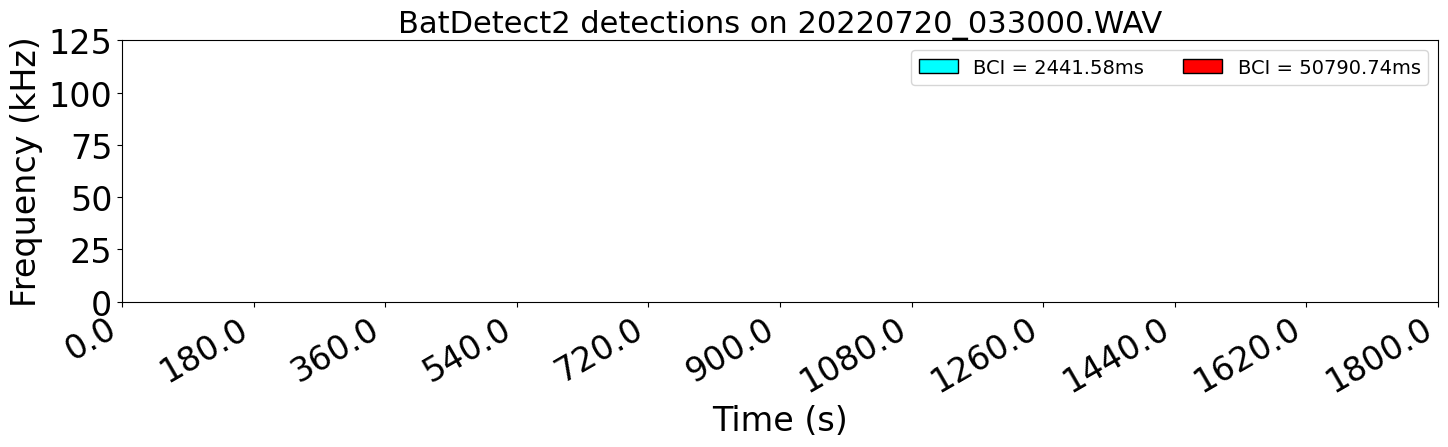

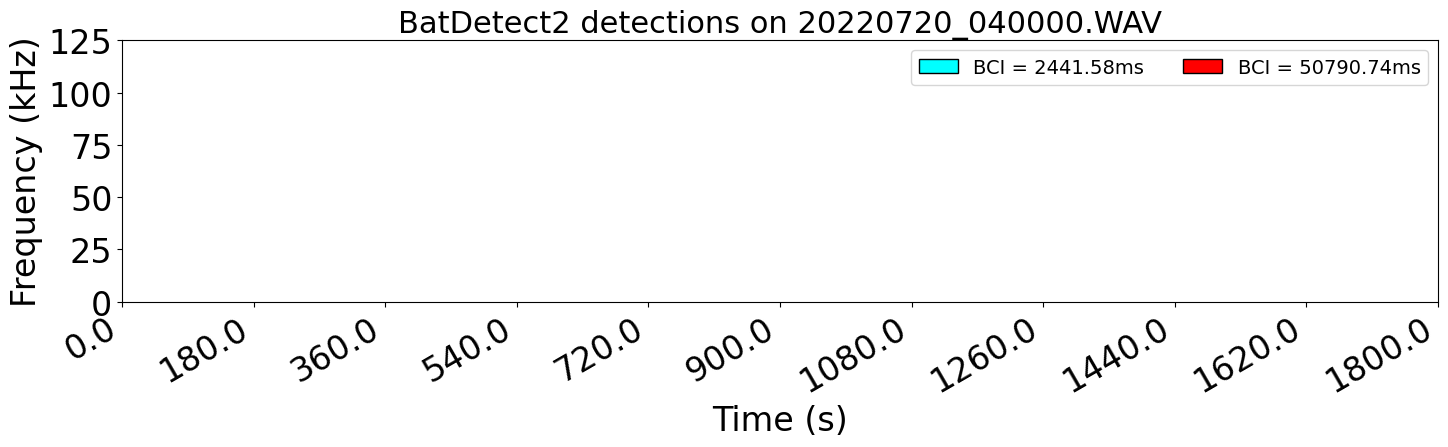

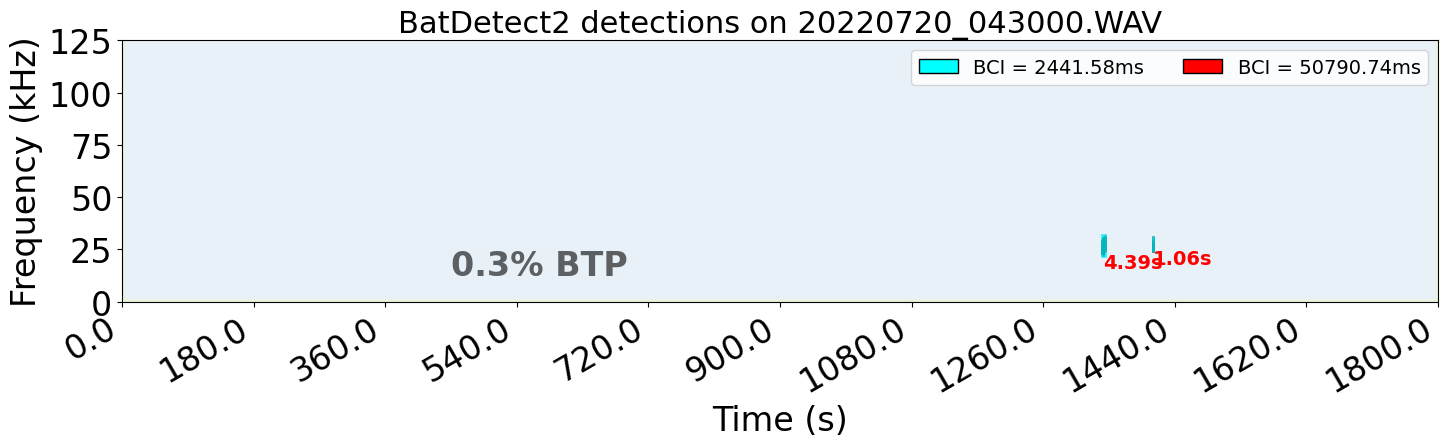

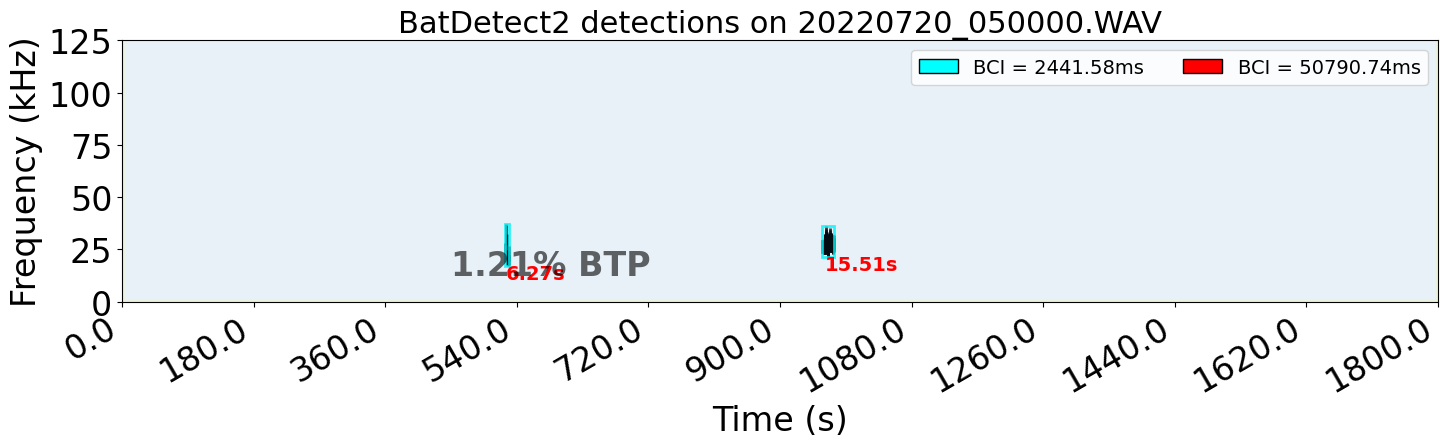

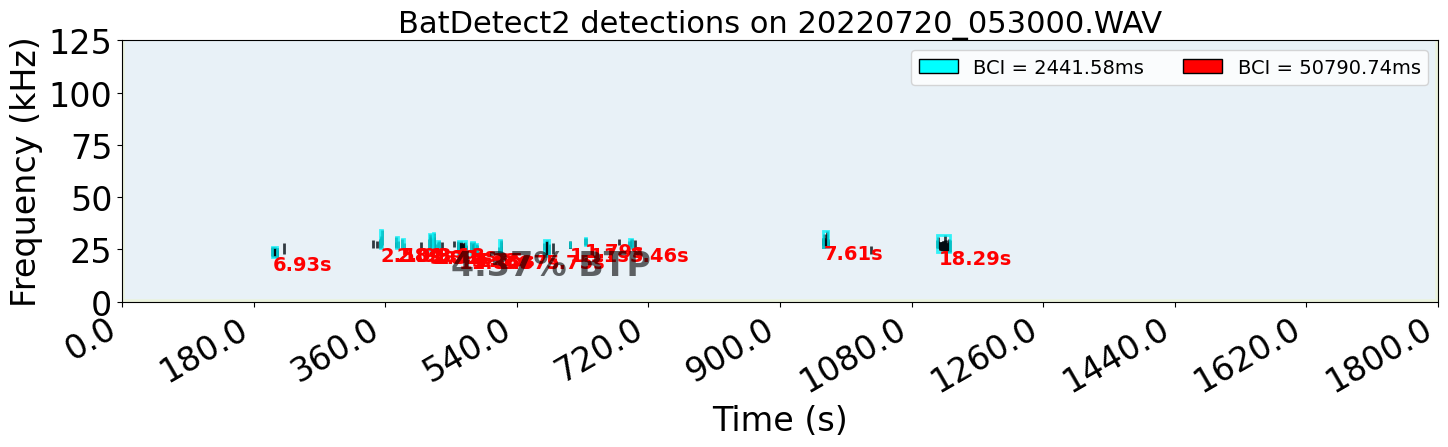

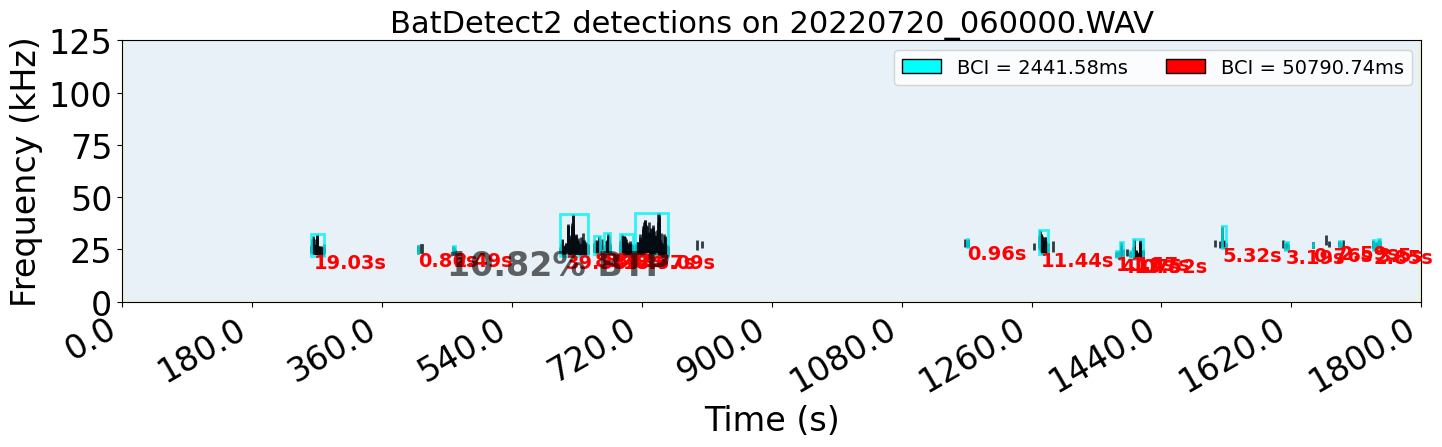

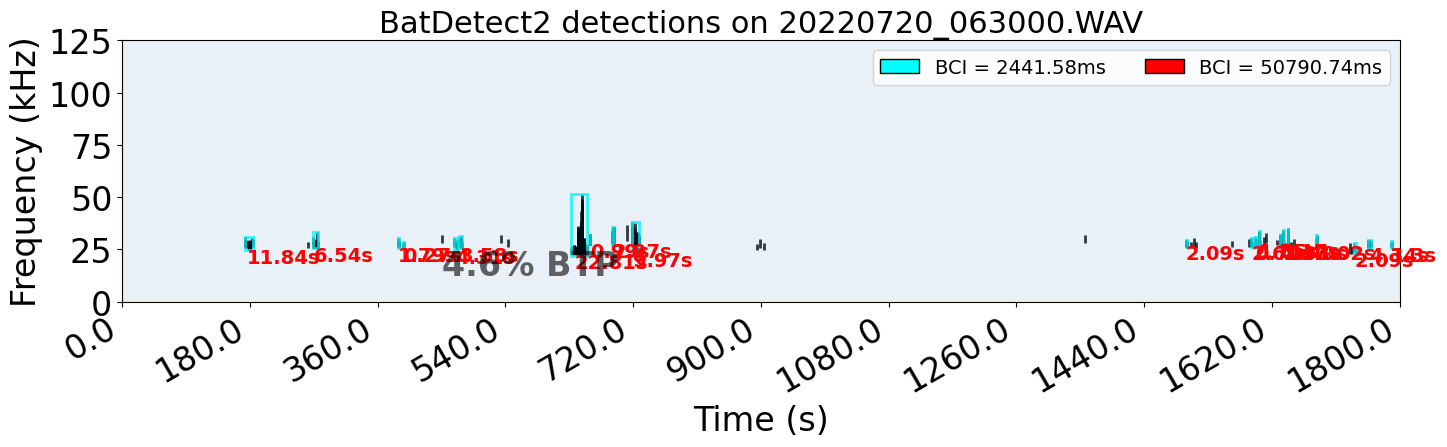

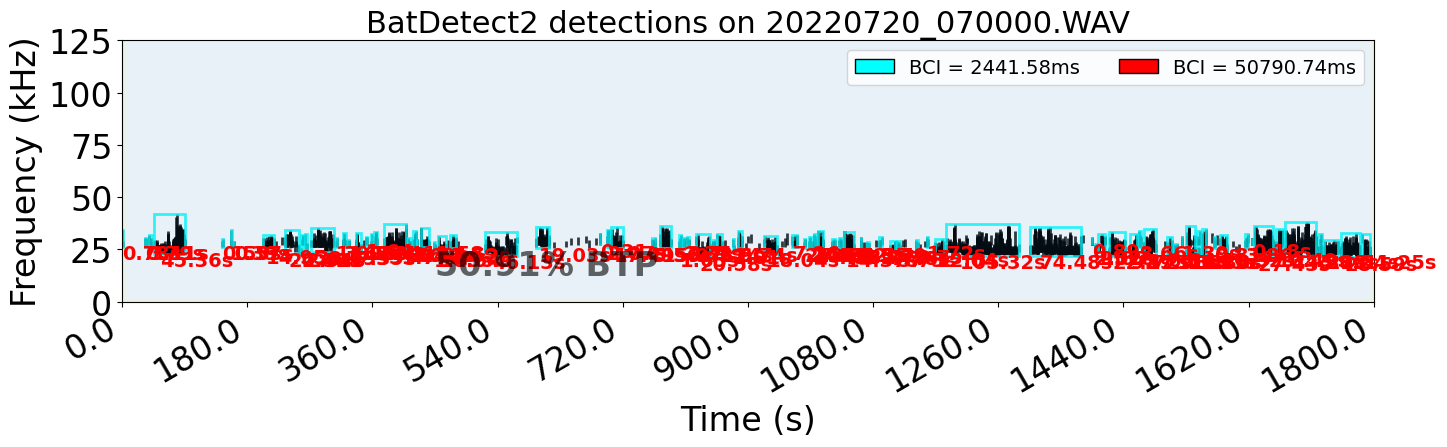

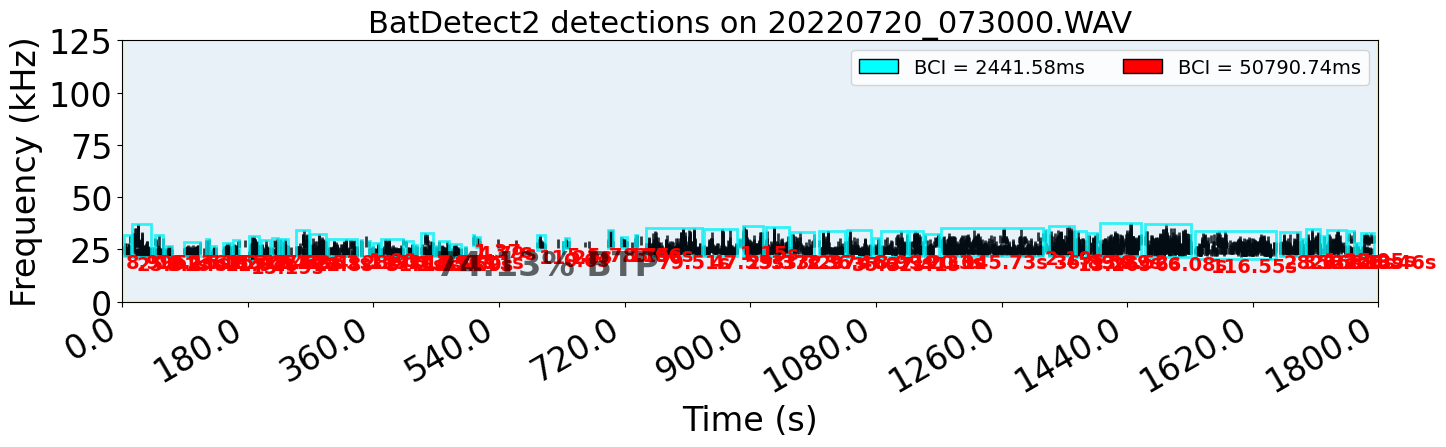

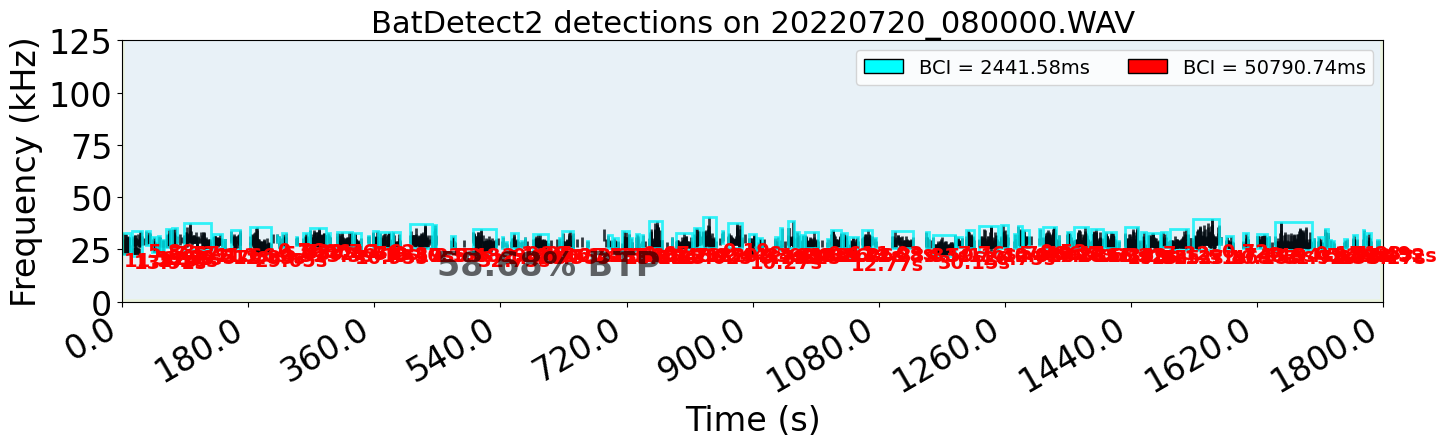

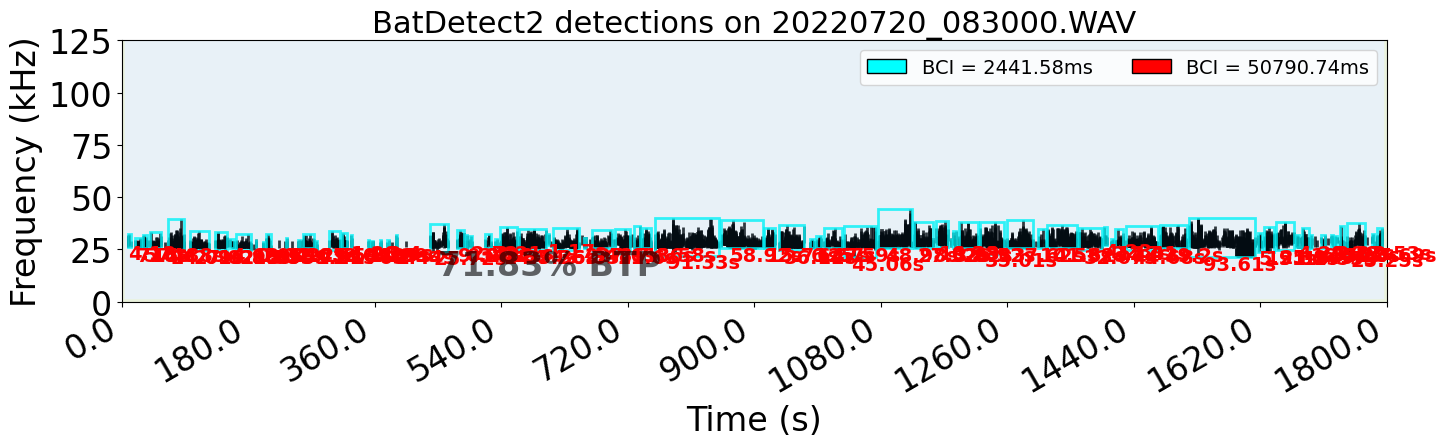

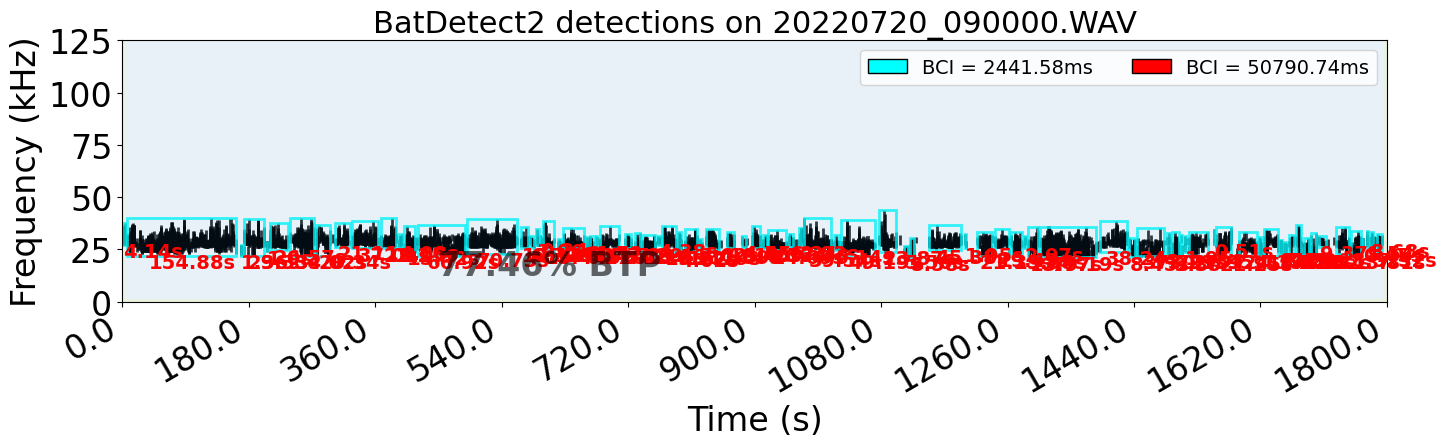

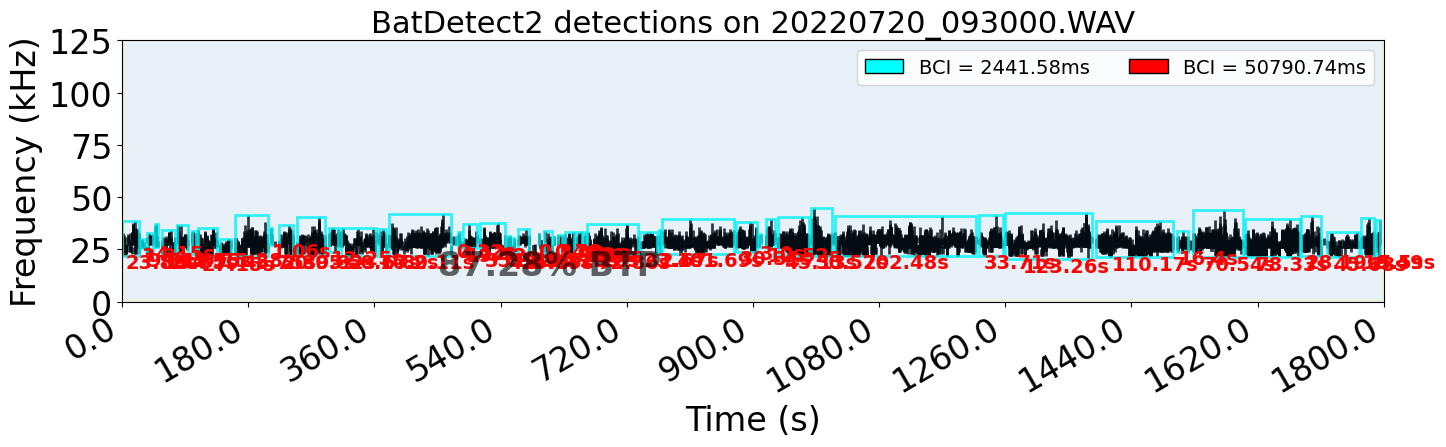

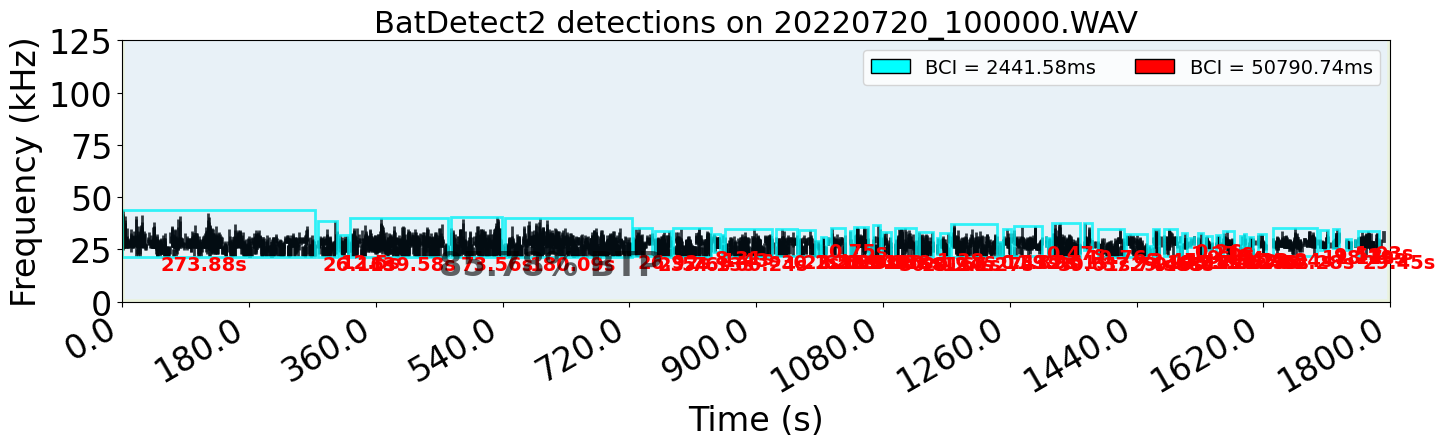

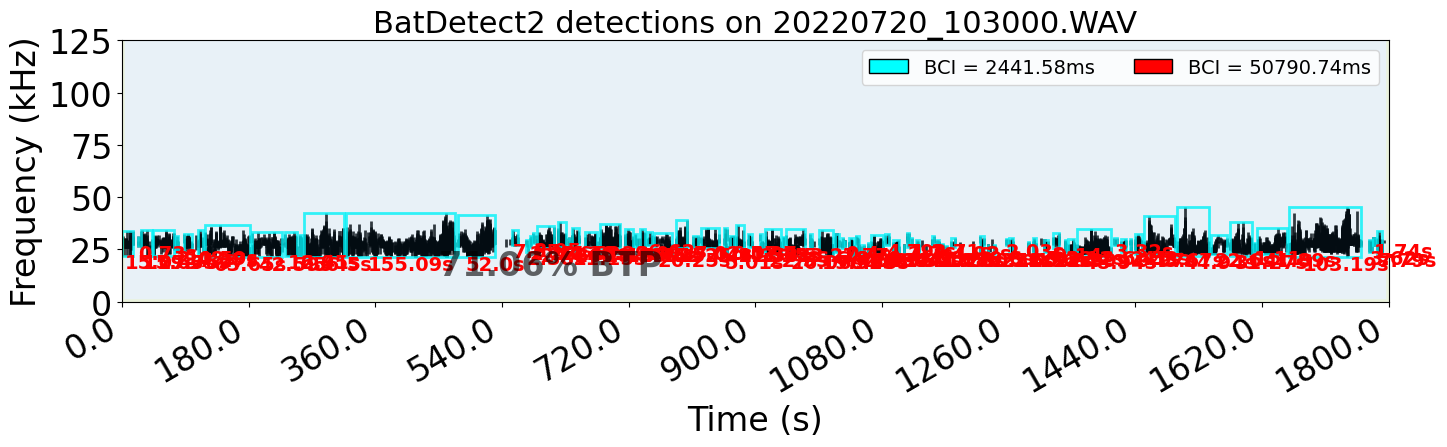

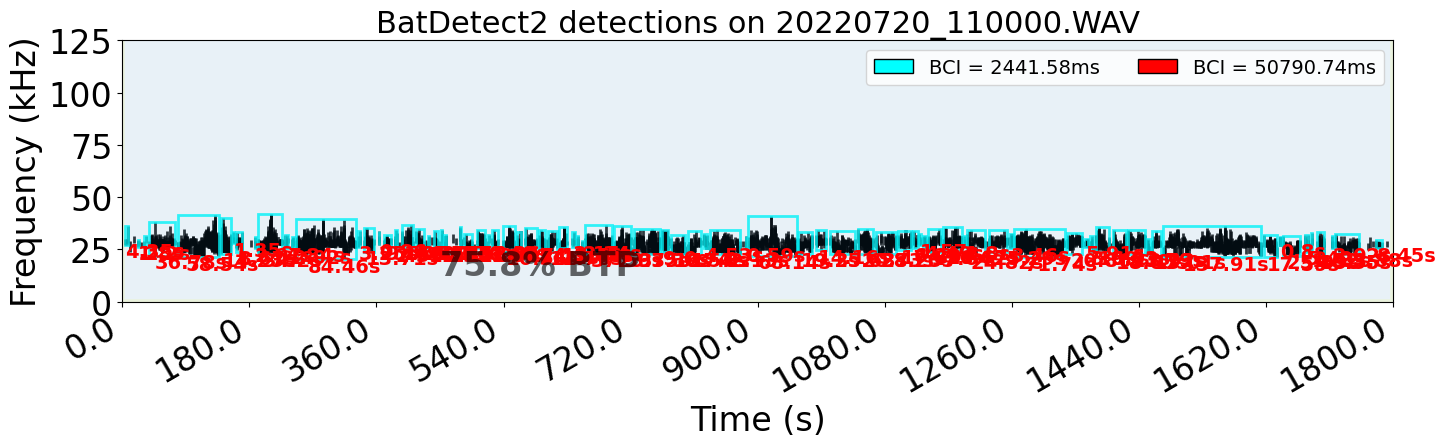

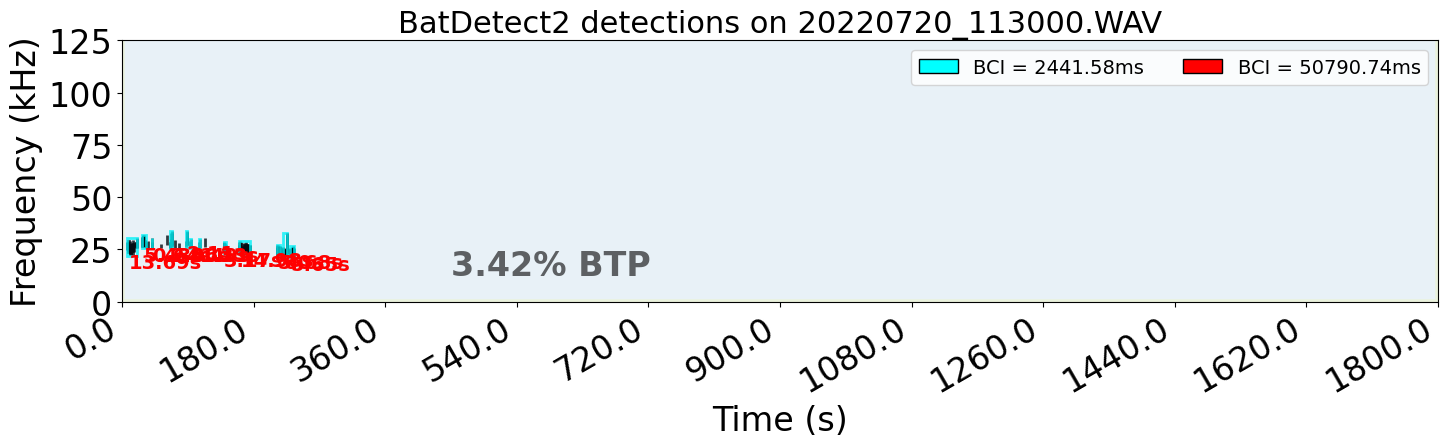

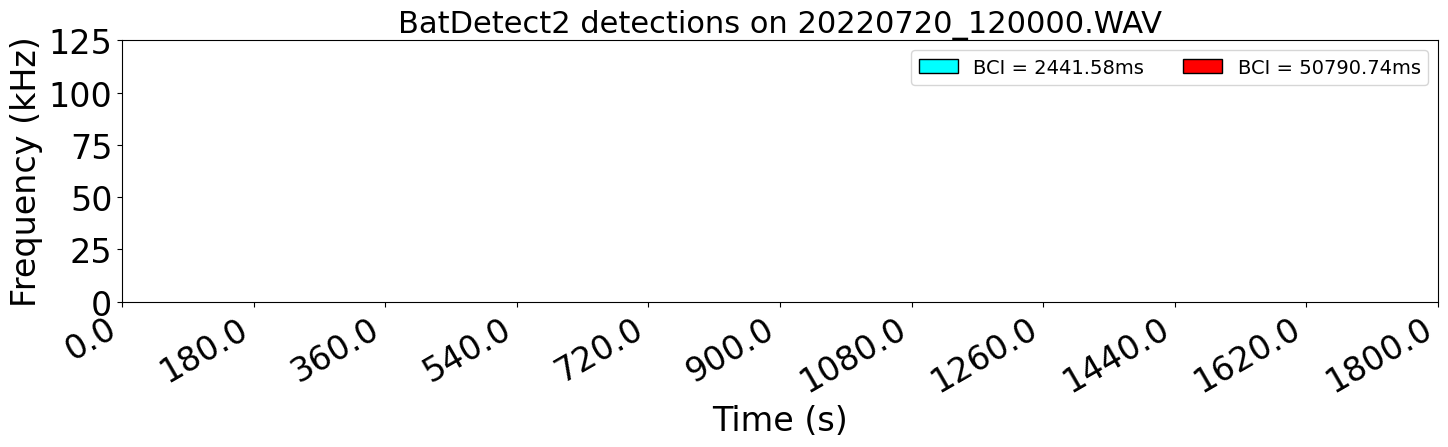

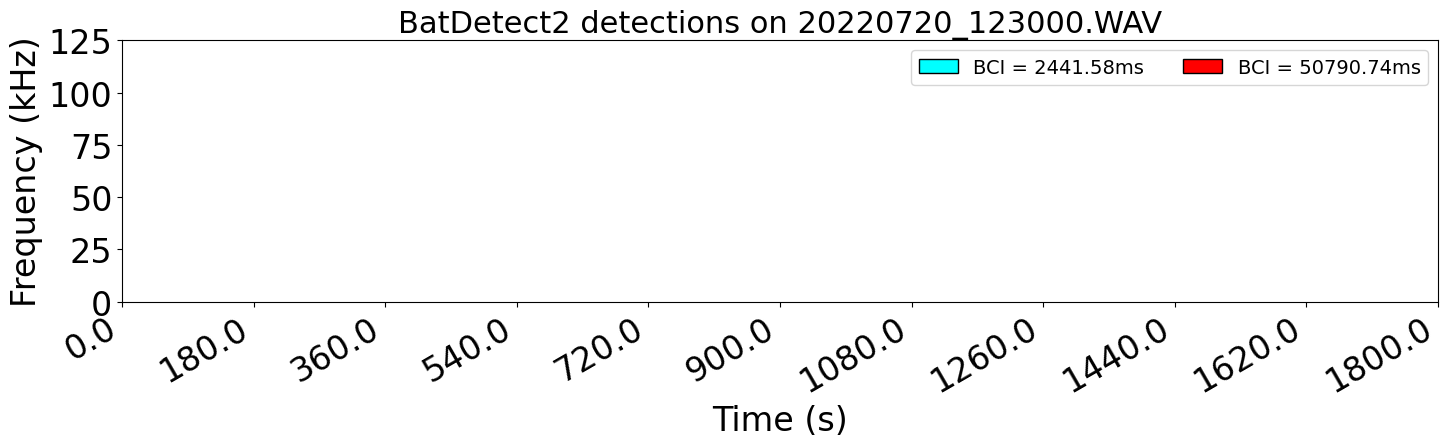

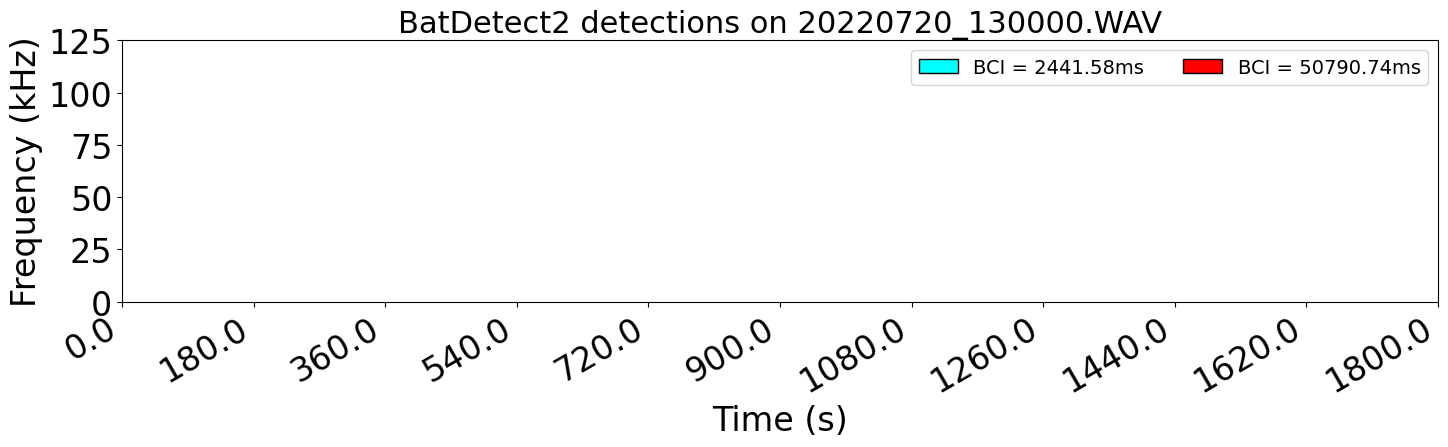

In [ ]:
for file in single_night_files:
    file_path = Path(file)
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 0
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
    file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

    plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
    plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
    if not(plot_dets.empty):
        plot_bouts = bout_metrics.loc[(bout_metrics['start_time_of_bout']>=file_dt_start)&(bout_metrics['end_time_of_bout']<=file_dt_end)]
        plot_bouts = plot_bouts.loc[(plot_bouts['start_time'] >= start)&(plot_bouts['end_time'] <= (start+duration))]
    else:
        plot_bouts = pd.DataFrame()
    # bt_plt.plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
    plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params)